In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from compute_risk import est_lam, est_k_theory
from generate_data import generate_data

def plot_colourline(x,y,c, ax):
    for i in np.arange(len(x)-1):        
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=cmap((c[i]-vmin)/(vmax-vmin)), linewidth=4)
    return ax
    
def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()

# Equivalence under RMT features

In [25]:
p = 1000
phi = 0.1
n = int(p/phi)
rho_ar1 = 0.25
sigma = 0.5

i_replace = 0
path_result = 'result/ex1/{}/'.format(i_replace)
df = pd.read_pickle(path_result+'res_ar1rho_{:.02f}.pkl'.format(rho_ar1))
df = df.rename(columns={'phi_s': 'psi'})
df = df.groupby(['phi','psi','lam','M']).mean().reset_index()
df = df[df['psi']!=np.inf]
df['k'] = p / df['psi']

# theoretical path through (lam, k) = (nu, n)
np.random.seed(0)
Sigma, beta0, X, Y, _, _, rho2, sigma2 = generate_data(
    p, phi, rho_ar1, sigma, func='quad', n_test=1)


nu = 1.
k = est_k_theory(nu, X=X)
psi = p/k
lam = 0
print(nu, lam, phi, psi)

psi_list = np.logspace(np.log10(phi), np.log10(psi), 51)
lam_list = (lam - nu) * (psi_list - phi) / (psi - phi) + nu
id_lam_list = np.argmin(np.abs(lam_list[:, None] - df['lam'].unique()[None, :]), 1)
id_ks_list = np.argmin(np.abs(p/psi_list[:, None] - np.sort(df['k'].unique()[None, :])), 1)

# empirical path through (lam, k) = (nu, n)
_df = df[df['M']==100].copy()
if i_replace==2:
    _df['dof'] = np.round(_df['dof'].values, 0)
else:
    _df['dof'] = np.round(_df['dof'].values/20, 0)*20
dof = _df[(_df['lam']==nu)&(_df['psi']==_df['phi'])].iloc[0,:]['dof']
_df = _df.pivot(index="lam", columns="k", values='dof') 
id_emp_k = np.where(_df.values == dof)[1]
id_emp_lam = np.where(_df.values == dof)[0]

1.0 0 0.1 2.1175167409694025


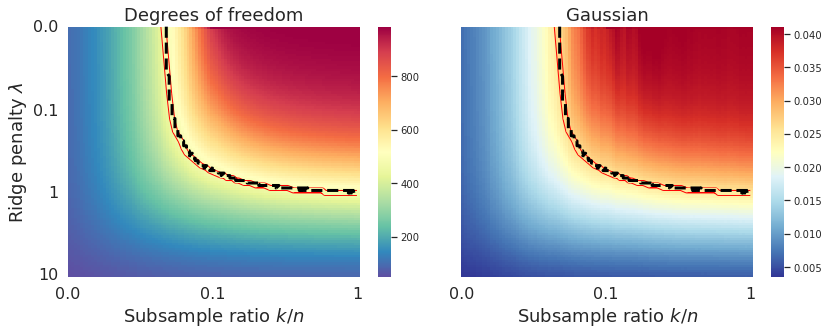

In [26]:
sns.set(font_scale=1.5)

fig, axes = plt.subplots(1,2,figsize=(12,5), sharex=True, sharey=True)
type_dict = {'dof':'Degrees of freedom','random_gau':'Gaussian'}

for i, type_str in enumerate(['dof', 'random_gau']):
    _df = df[df['M']==100]
    _df = _df.pivot(index="lam", columns="k", values=type_str)    

    cmap = sns.color_palette('RdYlBu_r' if i==1 else 'Spectral_r', as_cmap=True)
    
    vmax = np.nanquantile(_df.values, 0.99)
    vmin = np.nanquantile(_df.values, 0.001)
    vmin = np.nanmin(_df.values)

    
    sns.heatmap(_df, ax=axes[i], cmap=cmap, vmin=vmin, vmax=vmax)
    
    axes[i].set_title(type_dict[type_str])
    axes[i].set_xlabel('')
    axes[i].set_xticks([])
    axes[i].set_xticks([], minor=True)
    ks = np.sort((p/np.array([0.1, 1., 10.])).astype(int))
    ticks = np.where(np.in1d(np.array(_df.columns), ks))[0]
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in ks/n], 
                              rotation=0, fontsize=16)
    axes[i].figure.axes[-1].tick_params(labelsize=10)

    if i_replace<2:    
        axes[i].plot(id_ks_list, id_lam_list, dashes=[1., 0], c='red', linewidth=6)
        axes[i] = plot_colourline(id_ks_list, id_lam_list, _df.values[id_lam_list, id_ks_list], axes[i])
    axes[i].plot(id_emp_k, id_emp_lam, '--', color='black', lw=3, clip_on=False)
    
for i in range(2):
    lams = [0,  0.1, 1., 10.]
    ticks = np.where(np.in1d(np.array(_df.index), lams))[0]
    axes[i].set_yticks(ticks)
    axes[i].set_yticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in lams ], fontsize=16)
        
    axes[i].set_ylabel('')
    axes[i].set_xlabel('Subsample ratio $k/n$')
axes[0].set_ylabel('Ridge penalty $\lambda$')

fig.tight_layout()
plt.savefig('result/fig_equiv_est_{}.pdf'.format(i_replace), bbox_inches='tight', pad_inches=0, dpi=300)

# Equivalence under general features

In [41]:
from sklearn.metrics.pairwise import pairwise_kernels

feature_list = ['RMT', 'kernel', 'rf']
p = 500
phi = 0.1
n = int(p/phi)
sigma = .5
rho_ar1 = 0.25
df_list = []
ids_list = []
i_replace = 0
for i, feature_name in enumerate(feature_list):
    path_result = 'result/ex2/{}/{}/'.format(feature_name,i_replace)

    df = pd.read_pickle('{}res_ar1rho_{:.02f}.pkl'.format(path_result, rho_ar1))
    df = df.rename(columns={'phi_s': 'psi'})

    df = df.groupby(['phi','psi','lam','M']).mean().reset_index()
    df = df[df['psi']!=np.inf]
    df['k'] = p / df['psi']

    if feature_name == 'RMT':
        d = p
        func = lambda x: x
        F = np.identity(p)
        factor = 10
    elif feature_name == 'rf':
        d = 2 * p
        func = lambda x: x * (x > 0)
        F = np.random.normal(0, 1/np.sqrt(d), size=(d, p))
        factor = 5
    elif feature_name == 'kernel':
        d = p
        F = np.identity(p)
        func = lambda x: x
        factor = 10

    # theoretical path through (lam, k) = (nu, n)
    np.random.seed(0)
    Sigma, beta0, X, Y, _, _, rho2, sigma2 = generate_data(
        d, phi, rho_ar1, sigma, func='quad', n_test=1)
    X = func(X @ F)
    nu = 1.
    if feature_name != 'kernel':
        k = est_k_theory(X=X, nu=nu)
    else:
        G = pairwise_kernels(X, metric='poly', degree=3, coef0=0)
        k = est_k_theory(G=G, nu=nu)    
        
    psi = p/k
    lam = 0
    print(nu, lam, phi, psi)

    psi_list = np.logspace(np.log10(phi), np.log10(psi), 51)
    lam_list = (lam - nu) * (psi_list - phi) / (psi - phi) + nu
    id_lam_list = np.argmin(np.abs(lam_list[:, None] - df['lam'].unique()[None, :]), 1)
    id_ks_list = np.argmin(np.abs(p/psi_list[:, None] - np.sort(df['k'].unique()[None, :])), 1)

    # empirical path through (lam, k) = (nu, n)
    _df = df[df['M']==100].copy()

    _df['dof'] = np.round(_df['dof'].values/factor, 0)*factor
    dof = _df[(_df['lam']==nu)&(_df['psi']==_df['phi'])].iloc[0,:]['dof']
    _df = _df.pivot(index="lam", columns="k", values='dof') 
    id_emp_k = np.where(_df.values == dof)[1]
    id_emp_lam = np.where(_df.values == dof)[0]
    ids_list.append((id_ks_list, id_lam_list, id_emp_k, id_emp_lam))
    df_list.append(df)


1.0 0 0.1 2.1181486514517562
1.0 0 0.1 0.20253656978978485
1.0 0 0.1 4.187218089714863


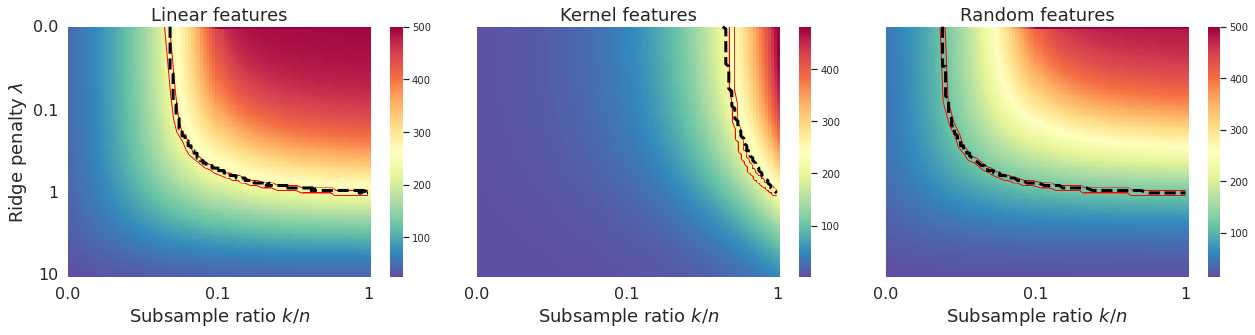

In [42]:
sns.set(font_scale=1.5)

fig, axes = plt.subplots(1,3,figsize=(18,5), sharex=True, sharey=True)
type_str = 'dof'
type_dict = {'dof':'Degrees of freedom'}
title_dict = {'RMT':'Linear features', 'rf':'Random features', 'kernel':'Kernel features'}
for i, feature_name in enumerate(['RMT', 'kernel', 'rf', ]):
    id_ks_list, id_lam_list, id_emp_k, id_emp_lam = ids_list[i]
    
    df = df_list[i]
    _df = df[df['M']==100]
    _df = _df.pivot(index="lam", columns="k", values=type_str)    

    cmap = sns.color_palette('Spectral_r', as_cmap=True)
    
    vmax = np.nanquantile(_df.values, 0.999)
    vmin = np.nanquantile(_df.values, 0.001)
    vmin = np.nanmin(_df.values)

    
    sns.heatmap(_df, ax=axes[i], cmap=cmap, vmin=vmin, vmax=vmax)
    
    axes[i].set_title(title_dict[feature_name])
    axes[i].set_xlabel('')
    axes[i].set_xticks([])
    axes[i].set_xticks([], minor=True)
    ks = np.sort((p/np.array([0.1, 1., 10.])).astype(int))
    ticks = np.where(np.in1d(np.array(_df.columns), ks))[0]
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in ks/n], 
                              rotation=0, fontsize=16)
    axes[i].figure.axes[-1].tick_params(labelsize=10)

    axes[i].plot(id_ks_list, id_lam_list, dashes=[1., 0], c='red', linewidth=6)
    axes[i] = plot_colourline(id_ks_list, id_lam_list, _df.values[id_lam_list, id_ks_list], axes[i])
    axes[i].plot(id_emp_k, id_emp_lam, '--', color='black', lw=3, clip_on=False)
    
for i in range(3):
    lams = [0,  0.1, 1., 10.]
    ticks = np.where(np.in1d(np.array(_df.index), lams))[0]
    axes[i].set_yticks(ticks)
    axes[i].set_yticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in lams ], fontsize=16)
        
    axes[i].set_ylabel('')
    axes[i].set_xlabel('Subsample ratio $k/n$')
axes[0].set_ylabel('Ridge penalty $\lambda$')

fig.tight_layout()
plt.savefig('result/fig_equiv_fea_{}.pdf'.format(i_replace), bbox_inches='tight', pad_inches=0, dpi=300)

# Risk equivalence

In [79]:
df = pd.DataFrame()
for i in range(3):
    _df = pd.read_pickle(path_result+'res_{}.pkl'.format(i+1))
    _df['i'] = i
    df = pd.concat([df, _df], axis=0)
df_val = df.melt(id_vars=['i', 'alpha','random_state','max_samples'], 
                  value_vars=[f'risk_val-{i}' for i in range(1, 101)], 
                  var_name='M', 
                  value_name='risk')
df_val['M'] = df_val['M'].str.extract('-(\d+)', expand=False).astype(int)

df_test = df.melt(id_vars=['i', 'alpha','random_state','max_samples'], 
                  value_vars=[f'risk_test-{i}' for i in range(1, 101)], 
                  var_name='M', 
                  value_name='risk')
df_test['M'] = df_test['M'].str.extract('-(\d+)', expand=False).astype(int)

df_val['1/M'] = 1-1/ df_val['M']
df_test['1/M'] = 1-1/ df_test['M']

mse = 1.9370091515536012

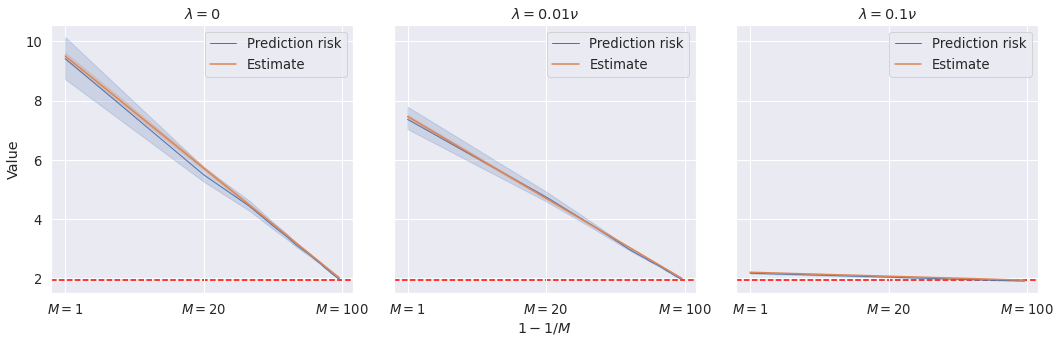

In [84]:
sns.set(font_scale=1.2)
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
for i in range(3):
    sns.lineplot(df_test[df_test['i']==i], x='1/M', y='risk', lw=1, ax=axes[i], label='Prediction risk')
    sns.lineplot(df_val[(df_val['i']==i)], x='1/M', y='risk', ax=axes[i], label='Estimate')
    
    axes[i].axhline(mse, ls='--', color='red', zorder=-1)
    axes[i].set_xticks([0, 0.5, 1.])
    axes[i].set_xticklabels(['$M=1$', '$M=20$', '$M=100$'])

axes[0].set_ylabel('Value')
for i in range(3):
    axes[i].set_xlabel('')
    axes[i].legend()
axes[1].set_xlabel('$1 - 1/M$')    
axes[0].set_title('$\lambda=0$')
axes[1].set_title(r'$\lambda=0.01\nu$')
axes[2].set_title(r'$\lambda=0.1\nu$')
fig.tight_layout()
plt.savefig('result/fig_equiv_risk.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Real data information

In [32]:
for (data, model) in [('FashionMNIST', 'resnet-18_init'), ('CIFAR-10', 'resnet-18_pretrained'), 
    ('Flowers-102', 'resnet-50_pretrained'), ('Food-101', 'resnet-101_pretrained')]:
    path_result = 'result/ex6/{}_{}/'.format(data, model)
    with open('data_{}_{}.npz'.format(data, model), 'rb') as f:
        dat = np.load(f)
        X = dat['X_train']
        X_test = dat['X_test']

    print(data, model, X.shape, X_test.shape)

FashionMNIST resnet-18_init (60000, 512) (10000, 512)
CIFAR-10 resnet-18_pretrained (50000, 512) (10000, 512)
Flowers-102 resnet-50_pretrained (2040, 2048) (6149, 2048)
Food-101 resnet-101_pretrained (75750, 2048) (25250, 2048)


# Equivalence on real data

## CIFAR-10

In [2]:
from sklearn.preprocessing import StandardScaler

data = 'CIFAR-10'
model = 'resnet-18_pretrained'

with open('data_{}_{}.npz'.format(data, model), 'rb') as f:
    data = np.load(f)
    X = data['X_train']
    X_test = data['X_test']
    Ys = data['Y_train']
    Ys_test = data['Y_test']

n, p = X.shape

X = X / np.linalg.norm(X, axis=1, keepdims=True) * np.sqrt(p)
X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True) * np.sqrt(p)

scaler = StandardScaler(with_std=False).fit(Ys)
Ys = scaler.transform(Ys)
Ys_test = scaler.transform(Ys_test)

In [3]:
data = 'CIFAR-10'
model = 'resnet-18_pretrained'
path_result = 'result/ex4/{}_{}/'.format(data, model)

p = 512
n = 50000
phi = p/n
df = pd.read_pickle(path_result+'res_df.pkl')
df = df.groupby(['phi','psi','lam','M']).mean().reset_index()
df = df[df['psi']!=np.inf]
df['k'] = p / df['psi']

# theoretical path through (lam, k) = (nu, n)
nu = 0.01
k = est_k_theory(nu, X=X)
psi = p/k
lam = 0
print(nu, lam, phi, psi)

psi_list = np.logspace(np.log10(phi), np.log10(psi), 51)
lam_list = (lam - nu) * (psi_list - phi) / (psi - phi) + nu
id_lam_list = np.argmin(np.abs(lam_list[:, None] - df['lam'].unique()[None, :]), 1)
id_ks_list = np.argmin(np.abs(p/psi_list[:, None] - np.sort(df['k'].unique()[None, :])), 1)

# empirical path through (lam, k) = (nu, n)
_df = df[df['M']==100].copy()
_df['dof'] = np.round(_df['dof'].values, 0)
dof = _df[(_df['lam']==_df['lam'].values[25])&(_df['psi']==_df['phi'])].iloc[0,:]['dof']
_df = _df.pivot(index="lam", columns="k", values='dof') 
id_emp_k = np.where(_df.values == dof)[1]
id_emp_lam = np.where(_df.values == dof)[0]

0.01 0 0.01024 1.1823763704240215


In [4]:
data = 'CIFAR-10'
model = 'resnet-18_pretrained'
path_result = 'result/ex5/{}_{}/'.format(data, model)

for i_class in range(9):
    _df = pd.read_pickle(path_result+'res_risk_{}.pkl'.format(i_class))
    _df = _df.groupby(['phi','psi','lam','M']).mean().reset_index()
    _df = _df[_df['psi']!=np.inf]
    if i_class==0:
        df_risk = _df
    else:
        df_risk[['est_err', 'train_err', 'pred_in', 'pred_out', 'dof']] += _df[['est_err', 'train_err', 'pred_in', 'pred_out', 'dof']]

df_risk['k'] = p / df_risk['psi']

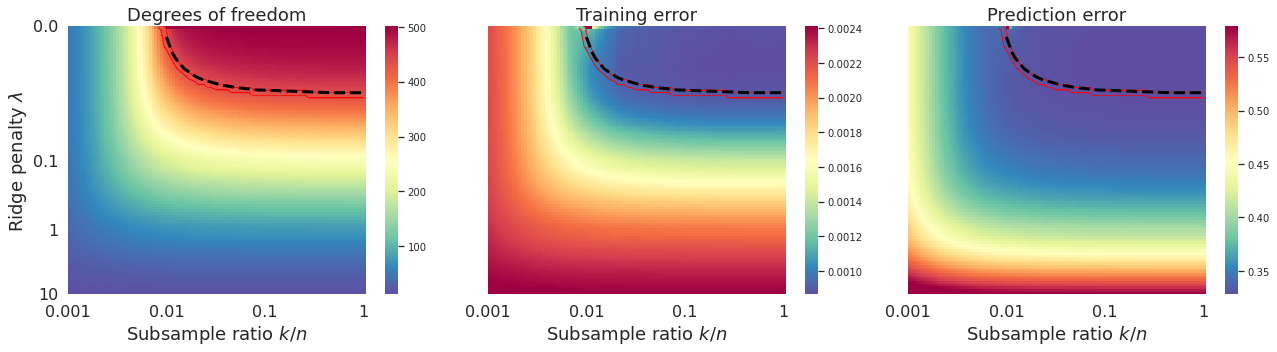

In [5]:
sns.set(font_scale=1.5)

fig, axes = plt.subplots(1,3,figsize=(18,5), sharex=True, sharey=True)
type_dict = {'dof':'Degrees of freedom', 'pred_in':'Training error','pred_out':'Prediction error'}

for i, type_str in enumerate(['dof', 'pred_in', 'pred_out']):
    if i==0:
        _df = df[df['M']==100]
    else:
        _df = df_risk[df_risk['M']==100]

    _df['k'] = _df['k'].astype(int)
    _df = _df.pivot(index="lam", columns="k", values=type_str)    

    cmap = sns.color_palette('Spectral_r', as_cmap=True)
    
    vmax = np.nanquantile(_df.values, 0.99)
    vmin = np.nanquantile(_df.values, 0.001)

    
    sns.heatmap(_df, ax=axes[i], cmap=cmap, vmin=vmin, vmax=vmax)
    
    axes[i].set_title(type_dict[type_str])
    axes[i].set_xlabel('')
    axes[i].set_xticks([])
    axes[i].set_xticks([], minor=True)
    ks = np.append(np.sort((p/np.array([0.1, 1., 10])).astype(int)), 49999)
    ticks = np.where(np.in1d(np.array(_df.columns), ks))[0]
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels([ f"{x:.03f}" if x<1e-2 else f"{x:.02f}" if x<1e-1 else f"{x:.01f}" if x<0.9 else f"{x:.0f}" for x in ks/n], 
                              rotation=0, fontsize=16)
    axes[i].figure.axes[-1].tick_params(labelsize=10)

    axes[i].plot(id_ks_list, id_lam_list, dashes=[1., 0], c='red', linewidth=6)
    axes[i] = plot_colourline(id_ks_list, id_lam_list, _df.values[id_lam_list, id_ks_list], axes[i])


    axes[i].plot(id_emp_k, id_emp_lam, '--', color='black', lw=3, clip_on=False)
    


for i in range(3):
    lams = [0,  0.1, 1., 10]
    ticks = np.where(np.in1d(np.array(_df.index), lams))[0]
    ticks = np.append(ticks, len(_df.index))
    axes[i].set_yticks(ticks)
    axes[i].set_yticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in lams ], fontsize=16)
        
    axes[i].set_ylabel('')
    axes[i].set_xlabel('Subsample ratio $k/n$')
axes[0].set_ylabel('Ridge penalty $\lambda$')

fig.tight_layout()
plt.savefig('result/fig_equiv_{}_{}.pdf'.format(data, model), bbox_inches='tight', pad_inches=0, dpi=300)

## FashionMNIST

In [38]:
from sklearn.preprocessing import StandardScaler

data = "FashionMNIST"; model = 'resnet-18_init'
with open('data_{}_{}.npz'.format(data, model), 'rb') as f:
    data = np.load(f)
    X = data['X_train']
    X_test = data['X_test']
    Ys = data['Y_train']
    Ys_test = data['Y_test']

n, p = X.shape

X = X / np.linalg.norm(X, axis=1, keepdims=True) * np.sqrt(p)
X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True) * np.sqrt(p)

scaler = StandardScaler(with_std=False).fit(Ys)
Ys = scaler.transform(Ys)
Ys_test = scaler.transform(Ys_test)

In [39]:
data = "FashionMNIST"; model = 'resnet-18_init'
path_result = 'result/ex4/{}_{}/'.format(data, model)

phi = p/n
df = pd.read_pickle(path_result+'res_df.pkl')
df = df.groupby(['phi','psi','lam','M']).mean().reset_index()
df = df[df['psi']!=np.inf]
df['k'] = p / df['psi']

# theoretical path through (lam, k) = (nu, n)
nu = 0.01
k = est_k_theory(nu, X=X)
psi = p/k
lam = 0
print(nu, lam, phi, psi)

psi_list = np.logspace(np.log10(phi), np.log10(psi), 51)
lam_list = (lam - nu) * (psi_list - phi) / (psi - phi) + nu
id_lam_list = np.argmin(np.abs(lam_list[:, None] - df['lam'].unique()[None, :]), 1)
id_ks_list = np.argmin(np.abs(p/psi_list[:, None] - np.sort(df['k'].unique()[None, :])), 1)

# empirical path through (lam, k) = (nu, n)
_df = df[df['M']==100].copy()
_df['dof'] = np.round(_df['dof'].values, 0)
dof = _df[(_df['lam']==_df['lam'].values[25])&(_df['psi']==_df['phi'])].iloc[0,:]['dof']
_df = _df.pivot(index="lam", columns="k", values='dof') 
id_emp_k = np.where(_df.values == dof)[1]
id_emp_lam = np.where(_df.values == dof)[0]

0.01 0 0.008533333333333334 12.342254998137873


In [44]:
data = "FashionMNIST"; model = 'resnet-18_init'
path_result = 'result/ex5/{}_{}/'.format(data, model)

for i_class in range(3):
    _df = pd.read_pickle(path_result+'res_risk_{}.pkl'.format(i_class))
    _df = _df.groupby(['phi','psi','lam','M']).mean().reset_index()
    _df = _df[_df['psi']!=np.inf]
    if i_class==0:
        df_risk = _df
    else:
        df_risk[['est_err', 'train_err', 'pred_in', 'pred_out', 'dof']] += _df[['est_err', 'train_err', 'pred_in', 'pred_out', 'dof']]

df_risk['k'] = p / df_risk['psi']

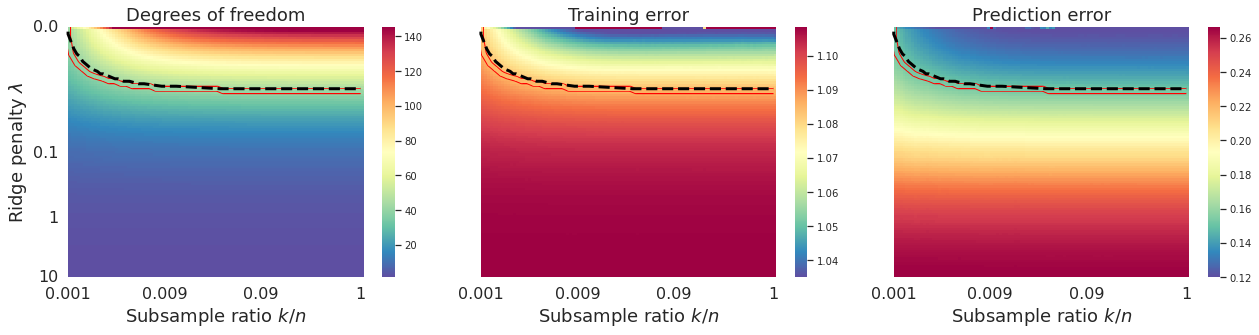

In [46]:
sns.set(font_scale=1.5)

fig, axes = plt.subplots(1,3,figsize=(18,5), sharex=True, sharey=True)
type_dict = {'dof':'Degrees of freedom', 'pred_in':'Training error','pred_out':'Prediction error'}

for i, type_str in enumerate(['dof', 'pred_in', 'pred_out']):
    if i==0:
        _df = df[df['M']==100]
    else:
        _df = df_risk[df_risk['M']==100]

    _df['k'] = _df['k'].astype(int)
    _df = _df.pivot(index="lam", columns="k", values=type_str)    

    cmap = sns.color_palette('Spectral_r', as_cmap=True)
    
    vmax = np.nanquantile(_df.values, 0.99)
    vmin = np.nanquantile(_df.values, 0.01)

    
    sns.heatmap(_df, ax=axes[i], cmap=cmap, vmin=vmin, vmax=vmax)
    
    axes[i].set_title(type_dict[type_str])
    axes[i].set_xlabel('')
    axes[i].set_xticks([])
    axes[i].set_xticks([], minor=True)
    ks = np.append(np.sort((p/np.array([0.1, 1., 10])).astype(int)), _df.columns[-1])
    ticks = np.where(np.in1d(np.array(_df.columns), ks))[0]
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels([ f"{x:.03f}" if x<1e-2 else f"{x:.02f}" if x<1e-1 else f"{x:.01f}" if x<0.9 else f"{x:.0f}" for x in ks/n], 
                              rotation=0, fontsize=16)
    axes[i].figure.axes[-1].tick_params(labelsize=10)

    axes[i].plot(id_ks_list, id_lam_list, dashes=[1., 0], c='red', linewidth=6)
    axes[i] = plot_colourline(id_ks_list, id_lam_list, _df.values[id_lam_list, id_ks_list], axes[i])


    axes[i].plot(id_emp_k, id_emp_lam, '--', color='black', lw=3, clip_on=False)
    


for i in range(3):
    lams = [0,  0.1, 1., 10]
    ticks = np.where(np.in1d(np.array(_df.index), lams))[0]
    ticks = np.append(ticks, len(_df.index))
    axes[i].set_yticks(ticks)
    axes[i].set_yticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in lams ], fontsize=16)
        
    axes[i].set_ylabel('')
    axes[i].set_xlabel('Subsample ratio $k/n$')
axes[0].set_ylabel('Ridge penalty $\lambda$')

fig.tight_layout()
plt.savefig('result/fig_equiv_{}_{}.pdf'.format(data, model), bbox_inches='tight', pad_inches=0, dpi=300)

## Flowers-102

In [5]:
from sklearn.preprocessing import StandardScaler

data = 'Flowers-102'; model = 'resnet-50_pretrained'
with open('data_{}_{}.npz'.format(data, model), 'rb') as f:
    data = np.load(f)
    X = data['X_train']
    X_test = data['X_test']
    Ys = data['Y_train']
    Ys_test = data['Y_test']

n, p = X.shape

X = X / np.linalg.norm(X, axis=1, keepdims=True) * np.sqrt(p)
X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True) * np.sqrt(p)

scaler = StandardScaler(with_std=False).fit(Ys)
Ys = scaler.transform(Ys)
Ys_test = scaler.transform(Ys_test)

In [33]:
data = 'Flowers-102'; model = 'resnet-50_pretrained'
path_result = 'result/ex4/{}_{}/'.format(data, model)

phi = p/n
df = pd.read_pickle(path_result+'res_df.pkl')
df = df.groupby(['phi','psi','lam','M']).mean().reset_index()
df = df[df['psi']!=np.inf]
df['k'] = p / df['psi']

# theoretical path through (lam, k) = (nu, n)
nu = 0.01
k = est_k_theory(nu, X=X)
psi = p/k
lam = 0
print(nu, lam, phi, psi)

psi_list = np.logspace(np.log10(phi), np.log10(psi), 51)
lam_list = (lam - nu) * (psi_list - phi) / (psi - phi) + nu
id_lam_list = np.argmin(np.abs(lam_list[:, None] - df['lam'].unique()[None, :]), 1)
id_ks_list = np.argmin(np.abs(p/psi_list[:, None] - np.sort(df['k'].unique()[None, :])), 1)

# empirical path through (lam, k) = (nu, n)
_df = df[df['M']==100].copy()
_df['dof'] = np.round(_df['dof'].values/10, 0)*10
dof = _df[(_df['lam']==_df['lam'].values[25])&(_df['psi']==_df['phi'])].iloc[0,:]['dof']
_df = _df.pivot(index="lam", columns="k", values='dof') 
id_emp_k = np.where(_df.values == dof)[1]
id_emp_lam = np.where(_df.values == dof)[0]

0.01 0 1.003921568627451 2.229479109649705


In [34]:
data = 'Flowers-102'; model = 'resnet-50_pretrained'
path_result = 'result/ex5/{}_{}/'.format(data, model)

for i_class in range(10):
    _df = pd.read_pickle(path_result+'res_risk_{}.pkl'.format(i_class))
    _df = _df.groupby(['phi','psi','lam','M']).mean().reset_index()
    _df = _df[_df['psi']!=np.inf]
    if i_class==0:
        df_risk = _df
    else:
        df_risk[['est_err', 'train_err', 'pred_in', 'pred_out', 'dof']] += _df[['est_err', 'train_err', 'pred_in', 'pred_out', 'dof']]

df_risk['k'] = p / df_risk['psi']

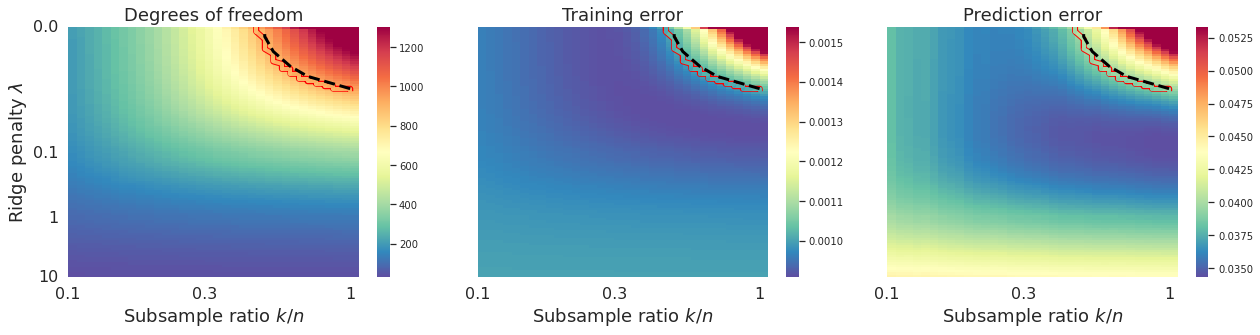

In [35]:
sns.set(font_scale=1.5)

fig, axes = plt.subplots(1,3,figsize=(18,5), sharex=True, sharey=True)
type_dict = {'dof':'Degrees of freedom', 'pred_in':'Training error','pred_out':'Prediction error'}

for i, type_str in enumerate(['dof', 'pred_in', 'pred_out']):
    if i==0:
        _df = df[df['M']==100]
    else:
        _df = df_risk[df_risk['M']==100]

    _df['k'] = _df['k'].astype(int)
    _df = _df.pivot(index="lam", columns="k", values=type_str)    

    cmap = sns.color_palette('Spectral_r', as_cmap=True)
    
    vmax = np.nanquantile(_df.values, 0.99)
    vmin = np.nanquantile(_df.values, 0.001)

    
    sns.heatmap(_df, ax=axes[i], cmap=cmap, vmin=vmin, vmax=vmax)
    
    axes[i].set_title(type_dict[type_str])
    axes[i].set_xlabel('')
    axes[i].set_xticks([])
    axes[i].set_xticks([], minor=True)
    ks = np.append(np.sort((p/np.array([ 10])).astype(int)), np.append(625,_df.columns[-1]))
    ticks = np.where(np.in1d(np.array(_df.columns), ks))[0]
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels([ f"{x:.03f}" if x<1e-2 else f"{x:.02f}" if x<1e-1 else f"{x:.01f}" if x<0.9 else f"{x:.0f}" for x in ks/n], 
                              rotation=0, fontsize=16)
    axes[i].figure.axes[-1].tick_params(labelsize=10)

    axes[i].plot(id_ks_list, id_lam_list, dashes=[1., 0], c='red', linewidth=6)
    axes[i] = plot_colourline(id_ks_list, id_lam_list, _df.values[id_lam_list, id_ks_list], axes[i])


    axes[i].plot(id_emp_k, id_emp_lam, '--', color='black', lw=3, clip_on=False)
    


for i in range(3):
    lams = [0,  0.1, 1., 10]
    ticks = np.where(np.in1d(np.array(_df.index), lams))[0]
    ticks = np.append(ticks, len(_df.index))
    axes[i].set_yticks(ticks)
    axes[i].set_yticklabels([ f"{x:.01f}" if x<1 else f"{x:.0f}" for x in lams ], fontsize=16)
        
    axes[i].set_ylabel('')
    axes[i].set_xlabel('Subsample ratio $k/n$')
axes[0].set_ylabel('Ridge penalty $\lambda$')

fig.tight_layout()
plt.savefig('result/fig_equiv_{}_{}.pdf'.format(data, model), bbox_inches='tight', pad_inches=0, dpi=300)

# Tuning on real data

In [27]:
M_list = np.array([1,2,5,10,100]).astype(str)
random_state = 0
df_list = []
df_val_list = []
df_test_list = []
for data, model in [('FashionMNIST', 'resnet-18_init'), ('CIFAR-10', 'resnet-18_pretrained'), 
    # ('Flowers-102', 'resnet-50_pretrained'), 
    ('CIFAR-100', 'resnet-50_pretrained'), 
    ('Food-101', 'resnet-101_pretrained')]:
    path_result = 'result/ex6/{}_{}/'.format(data, model)
    df = pd.read_pickle('{}res_sub.pkl'.format(path_result))
    df_list.append(df)

    df_val = df.melt(id_vars=['j', 'alpha','random_state','max_samples'], 
                    value_vars=[f'risk_val-{i}' for i in range(1, 101)], 
                    var_name='M', 
                    value_name='risk')
    df_val['M'] = df_val['M'].str.extract('-(\d+)', expand=False)

    df_test = df.melt(id_vars=['j', 'alpha','random_state','max_samples'], 
                    value_vars=[f'risk_test-{i}' for i in range(1, 101)], 
                    var_name='M', 
                    value_name='risk')
    df_test['M'] = df_test['M'].str.extract('-(\d+)', expand=False)

    df_val = df_val[df_val['M'].isin(M_list)]
    df_test = df_test[df_test['M'].isin(M_list)]
    df_val_list.append(df_val)
    df_test_list.append(df_test)

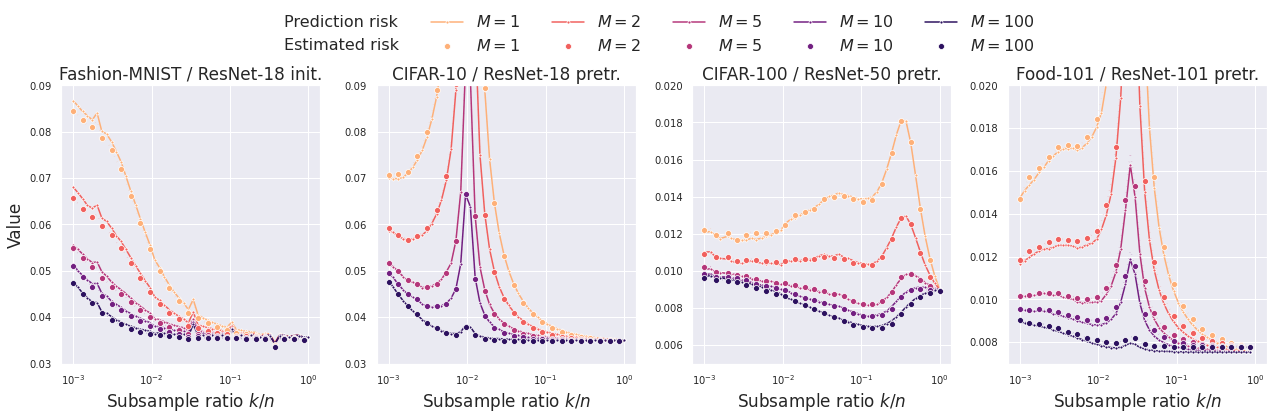

In [28]:
sns.set(font_scale=1.4)
fig, axes = plt.subplots(1,4,figsize=(18,6), sharex=True, sharey=False)

for j in range(4):
    df_test = df_test_list[j]
    df_val = df_val_list[j]
    sns.lineplot(df_test, x='max_samples', y='risk', hue='M', errorbar=None, 
        marker='.', palette=sns.color_palette('magma_r', n_colors=5),
        ax=axes[j])
    sns.lineplot(df_val, x='max_samples', y='risk', hue='M', errorbar=None,
        dashes=(0.1,4), legend=False, palette=sns.color_palette('magma_r', n_colors=5),
        ax=axes[j])
    sns.lineplot(df_val[df_val['max_samples'].isin(df_val['max_samples'].unique()[::2])], x='max_samples', y='risk', hue='M', 
        errorbar=None, marker='o', dashes=(0.,4), palette=sns.color_palette('magma_r', n_colors=5),
        ax=axes[j])
        
title_list = ['Fashion-MNIST / ResNet-18 init.', 'CIFAR-10 / ResNet-18 pretr.', 
    # 'Flowers-102 / ResNet-50 pretr.', 
    'CIFAR-100 / ResNet-50 pretr.',
    'Food-101 / ResNet-101 pretr.' 
]
for j in range(4):
    axes[j].set_xlabel('Subsample ratio $k/n$')
    axes[j].set_ylabel('')
    axes[j].set_title(title_list[j])
    
axes[0].set_ylabel('Value')
axes[0].set_ylim([0.03,0.09])
axes[1].set_ylim([0.03,0.09])
axes[2].set_ylim([0.005,0.02])
axes[3].set_ylim([0.007,0.02])
axes[0].set_xscale('log')

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
_, indices = np.unique(labels, return_index=True)
for j in range(4):
    axes[j].get_legend().remove()
    axes[j].tick_params(axis='both', which='major', labelsize=10)

handles = [matplotlib.lines.Line2D([], [], color="none")] + handles[:5] +\
    [matplotlib.lines.Line2D([], [], color="none")] + handles[5:]
handles = np.array(handles).reshape(2,-1).reshape(-1,order='F').tolist()
labels = ['Prediction risk'] + ['$M={}$'.format(l) for l in labels[:5]] +\
    ['Estimated risk'] + ['$M={}$'.format(l) for l in labels[5:]]
labels = np.array(labels).reshape(2,-1).reshape(-1,order='F').tolist()

legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=6, title='', frameon=False, fontsize=16)
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.savefig('result/fig_est_real_data.pdf', bbox_inches='tight', pad_inches=0, dpi=300)